In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime.fake_provider import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict
import numpy as np

In [4]:
def count_gates(qc: QuantumCircuit):
    gate_count = { qubit: 0 for qubit in qc.qubits }
    for gate in qc.data:
        for qubit in gate.qubits:
            gate_count[qubit] += 1
    return gate_count

def remove_idle_wires(qc: QuantumCircuit):
    qc_out = qc.copy()
    gate_count = count_gates(qc_out)
    for qubit, count in gate_count.items():
        if count == 0:
            qc_out.qubits.remove(qubit)
    return qc_out

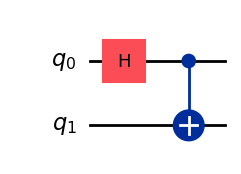

In [5]:

# Example circuits
qc_ref = QuantumCircuit(2)
qc_ref.h(0)

qc_ref.cx(0, 1)


sv_ref = Statevector.from_instruction(qc_ref)
qc_ref.draw('mpl', idle_wires=True, fold=60)



In [6]:
backend = FakeTorino()

In [118]:
from qiskit import QuantumCircuit

def copy_circuit_no_empty_lines(qc: QuantumCircuit):
    # Step 1: Store instructions and track used wires
    instructions = []
    used_qubits = set()
    used_clbits = set()

    for instr, qargs, cargs in qc.data:
        instructions.append((instr.copy(), qargs, cargs))
        used_qubits.update(qargs)
        used_clbits.update(cargs)

    # Step 2: Sort wires by their index in the original circuit
    used_qubits = sorted(used_qubits, key=lambda q: qc.qubits.index(q))
    used_clbits = sorted(used_clbits, key=lambda c: qc.clbits.index(c))

    # Step 3: Create new circuit with only used wires
    qc_copy = QuantumCircuit(len(used_qubits), len(used_clbits))

    # Create mapping from old wires to new wires
    qubit_map = {old_q: qc_copy.qubits[i] for i, old_q in enumerate(used_qubits)}
    clbit_map = {old_c: qc_copy.clbits[i] for i, old_c in enumerate(used_clbits)}

    # Step 4: Append instructions to new circuit
    for instr, qargs, cargs in instructions:
        mapped_qargs = [qubit_map[q] for q in qargs]
        mapped_cargs = [clbit_map[c] for c in cargs]
        qc_copy.append(instr, mapped_qargs, mapped_cargs)

    return qc_copy


/var/folders/_k/qjlhflx94s97dht_ggl_nt080000gn/T/ipykernel_77625/3336136814.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


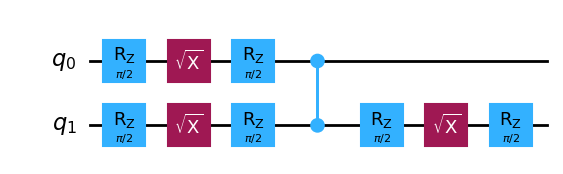

In [119]:
seed = 42

# Make a pass manager with our desired optimization level and backend
pm_lv0 = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)

# Run for our random circuit
tr_lv0 = pm_lv0.run(qc_ref)
phase = tr_lv0.global_phase
tr_lv0 = copy_circuit_no_empty_lines(tr_lv0)

# uncomment the next line to draw circuit
tr_lv0.draw('mpl', idle_wires=True, fold=60)

In [9]:
sv_transpiled = Statevector.from_instruction(tr_lv0)
# Check if the transpiled circuit matches the reference statevector
print("Transpiled circuit matches reference statevector:", sv_transpiled.equiv(sv_ref))

Transpiled circuit matches reference statevector: True


In [10]:
sv_ref

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


In [11]:

def parallel_constant(v1, v2, tol=1e-9):
    v1 = np.asarray(v1, dtype=float)
    v2 = np.asarray(v2, dtype=float)
    
    # Both zero vector case
    if np.allclose(v1, 0, atol=tol) and np.allclose(v2, 0, atol=tol):
        return None  # undefined constant for zero-zero
    
    # If one is zero vector, cannot define a constant
    if np.allclose(v1, 0, atol=tol) or np.allclose(v2, 0, atol=tol):
        return None
    
    # Avoid division by zero: compute ratio where v2 is nonzero
    nonzero_mask = np.abs(v2) > tol
    if not np.any(nonzero_mask):
        return None
    
    ratios = v1[nonzero_mask] / v2[nonzero_mask]
    
    # Check if all ratios are (almost) equal
    if np.allclose(ratios, ratios[0], atol=tol):
        return ratios[0]  # the parallel constant
    else:
        return None  # not parallel

In [ ]:
from math import exp, sin, cos
import numpy as np
# convert sv_transpiled to a numpy vector
sv_transpiled = np.array(sv_transpiled)
# Rotate by phase 
rotation = cos(phase) + 1j * sin(phase)
rotated = sv_transpiled * rotation

# check if vectors are parallel
c = parallel_constant(sv_ref, rotated)

print(rotated)
print(np.array(sv_ref))

# These two are equal! We did it!


[ 7.07106781e-01+2.00513608e-15j -1.47476458e-31+5.55111512e-17j
 -1.40037088e-31+5.55111512e-17j  7.07106781e-01+1.91037261e-15j]
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


/Users/bigman/Documents/Programming/qiskit_hackathon/.venv/lib/python3.12/site-packages/qiskit/quantum_info/states/statevector.py:118: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(self.data, dtype=dtype, copy=copy)
/var/folders/_k/qjlhflx94s97dht_ggl_nt080000gn/T/ipykernel_77625/1916958806.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  v2 = np.asarray(v2, dtype=float)


In [ ]:


EPSILON = 0.20  # 10% error tolerance
DELTA = 0.05   # 5% chance of failure (95% confidence)
seed = 0


# Test ertf on the two circuits
# erft_result = erft(tr_lv0, qc_ref, epsilon=EPSILON, delta=DELTA, seed=seed)
# print("ERTF result:", erft_result)




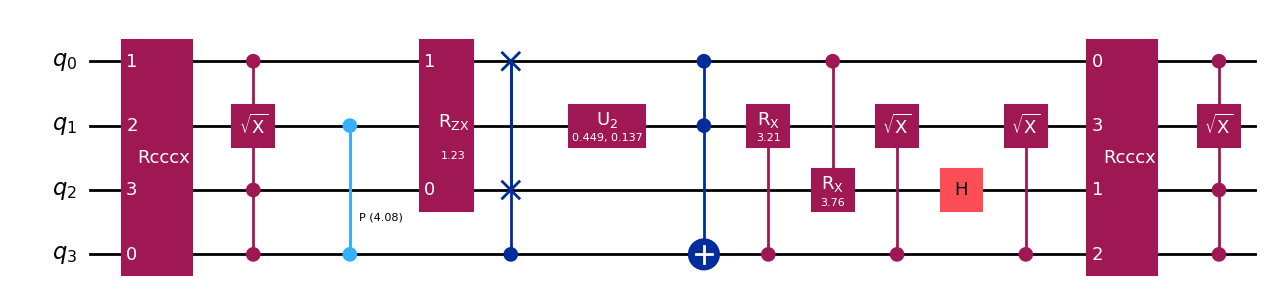

In [ ]:
from qiskit.circuit.random import random_circuit

## DO NOT CHANGE THE SEED NUMBER
seed = 103

## Create circuit

EPSILON = 0.20  # 10% error tolerance
DELTA = 0.10   # 5% chance of failure (95% confidence)

num_qubits = 3
depth = 10
qc1 = QuantumCircuit(num_qubits)
qc1 = random_circuit(num_qubits,depth,measure=False, seed=seed)


qc1.draw('mpl', idle_wires=True, fold=60)

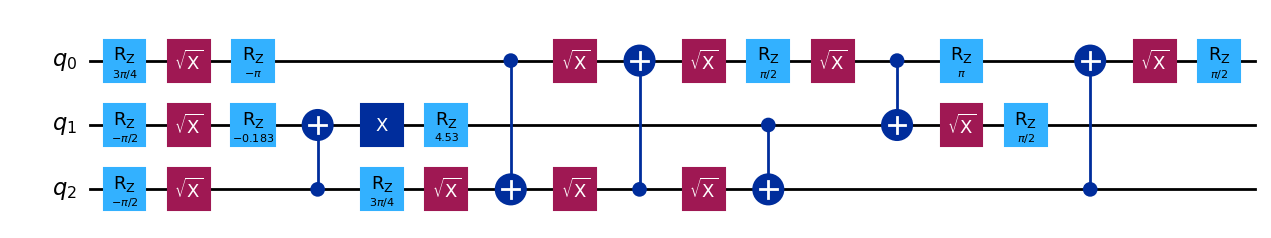

In [439]:

# Create a quantum circuit with 3 qubits
qc2 = QuantumCircuit(3)

# --- Column 1: Initial Rz rotations ---
qc2.rz(3 * np.pi / 4, 0)
qc2.rz(-np.pi / 2, 1)
qc2.rz(-np.pi / 2, 2)

# --- Column 2: Initial SX gates ---
qc2.sx(0)
qc2.sx(1)
qc2.sx(2)

# --- Column 3 & 4: Gates on q0, q1, and a CNOT ---
qc2.rz(-np.pi, 0)
qc2.rz(-0.183, 1)
qc2.cx(2, 1)
qc2.x(1)

# --- Column 5 & 6: Rz and SX gates ---
qc2.rz(4.53, 1)
qc2.rz(3 * np.pi / 4, 2)
qc2.sx(2)

# --- Columns 7-10: A series of CNOTs and SX gates ---
qc2.cx(0, 2)
qc2.sx(0)
qc2.sx(2)
qc2.cx(2, 0)
qc2.sx(0)
qc2.sx(2)

# --- Columns 11-15: CNOTs and various rotations ---
qc2.cx(1, 2)
qc2.rz(np.pi / 2, 0)
qc2.sx(0)
qc2.cx(0, 1)
qc2.rz(np.pi, 0)
qc2.sx(1)
qc2.rz(np.pi / 2, 1)

# --- Columns 16-18: Final CNOT and gates on q0 ---
qc2.cx(2, 0)
qc2.sx(0)
qc2.rz(np.pi / 2, 0)

# Display the circuit
# The 'mpl' option generates a high-quality image like the one you provided
qc2.draw('mpl', style='iqx')

In [440]:
erft_result = erft(qc1, qc2, epsilon=EPSILON, delta=DELTA, seed=seed)
print("ERTF result:", erft_result)

🔬 Starting ERFT for 3-qubit circuits...
   - ε (error tolerance): 0.2
   - δ (failure probability): 0.1
   - m (required samples): 38

🚀 Running 38 randomized trials...

📊 Results:
   - Total 'survival' counts: 8 / 38
   - Estimated Fidelity (F_hat): 0.2105
   - Decision Threshold (1 - ε): 0.8000
   - Outcome: F_hat < 1 - ε
ERTF result: ❌ Not equivalent


In [449]:
sv1 = Statevector.from_instruction(qc1)
sv2 = Statevector.from_instruction(qc2)

print(sv1, sv2)
# Check if the two circuits are equivalent
print("Are the two circuits equivalent?", sv1.equiv(sv2))

Statevector([ 0.40788658+0.j        , -0.27566389+0.08739543j,
              0.36739243+0.17718427j,  0.        +0.j        ,
              0.40788658+0.j        , -0.08739543+0.27566389j,
              0.36739243+0.17718427j,  0.        +0.j        ,
              0.        +0.j        ,  0.01006582+0.00144268j,
              0.        +0.j        , -0.04100291+0.28608372j,
              0.        +0.j        ,  0.2114602 -0.00613798j,
              0.        +0.j        , -0.00572074-0.19708557j],
            dims=(2, 2, 2, 2)) Statevector([-0.22214265+0.06900874j,  0.06900874+0.22214265j,
              0.42267013-0.13130271j,  0.13130271+0.42267013j,
             -0.13141072+0.06911675j, -0.06911675-0.13141072j,
             -0.42256211+0.22225066j,  0.22225066+0.42256211j],
            dims=(2, 2, 2))
Are the two circuits equivalent? False


In [450]:
from qiskit import QuantumCircuit
my_qubit = 0
def copy_circuit_no_empty_lines(qc: QuantumCircuit):
    global my_qubit
    # Step 1: Store instructions and track used wires
    virtual_to_physical_map = qc.layout.initial_layout.get_virtual_bits()
    inverted_dict = {value: key for key, value in virtual_to_physical_map.items()}
    print("inverted_dict:", inverted_dict)

    instructions = []
    used_qubits = set()
    used_clbits = set()

    for instr, qargs, cargs in qc.data:
        instructions.append((instr.copy(), qargs, cargs))
        used_qubits.update(qargs)
        used_clbits.update(cargs)


    used_qubits = sorted(used_qubits, key=lambda q: inverted_dict[qc.qubits.index(q)]._index)
    # print("used_qubits:", used_qubits)
    my_qubit = inverted_dict[qc.qubits.index(used_qubits[0])]
    # print("my_qubit:", my_qubit)
    used_clbits = sorted(used_clbits, key=lambda c: qc.clbits.index(c))

    # Step 3: Create new circuit with only used wires
    qc_copy = QuantumCircuit(len(used_qubits), len(used_clbits))

    # Create mapping from old wires to new wires
    qubit_map = {old_q: qc_copy.qubits[i] for i, old_q in enumerate(used_qubits)}
    clbit_map = {old_c: qc_copy.clbits[i] for i, old_c in enumerate(used_clbits)}

    # Step 4: Append instructions to new circuit
    for instr, qargs, cargs in instructions:
        mapped_qargs = [qubit_map[q] for q in qargs]
        mapped_cargs = [clbit_map[c] for c in cargs]
        qc_copy.append(instr, mapped_qargs, mapped_cargs)

    return qc_copy


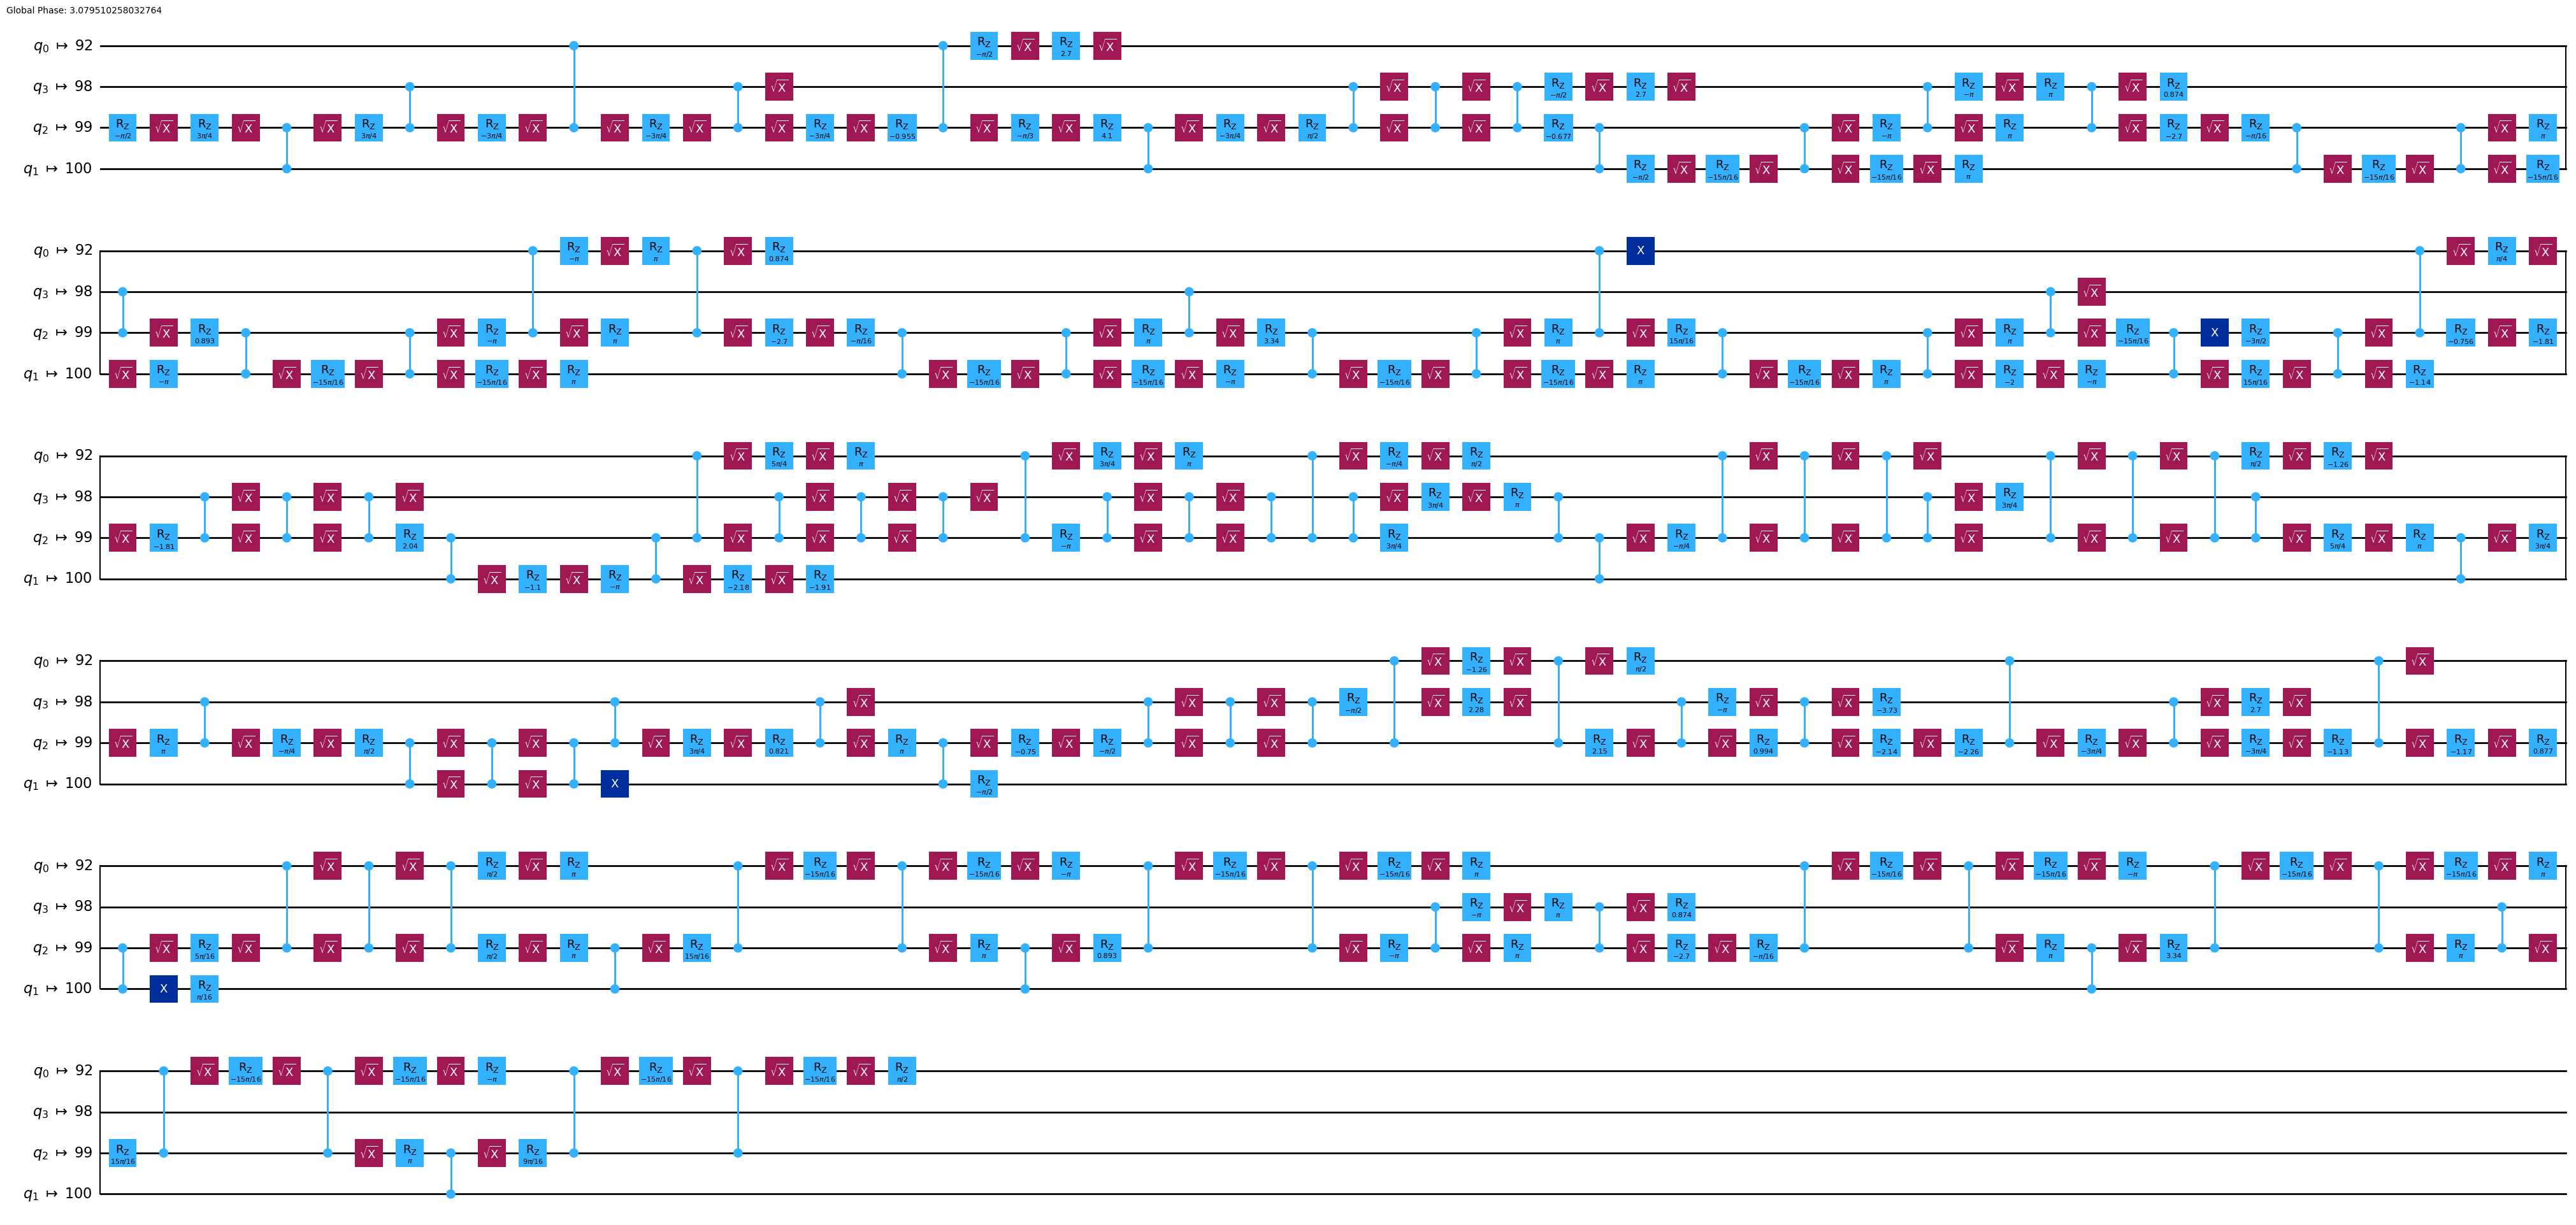

In [456]:
# Run for our random circuit
pm_lv3 = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed, approximation_degree=1)

tr_random = pm_lv3.run(qc1)
# print(dict(tr_random.layout.initial_layout.get_virtual_bits()))
tr_random.draw('mpl', idle_wires=False, fold=60)

inverted_dict: {99: <Qubit register=(4, "q"), index=2>, 100: <Qubit register=(4, "q"), index=1>, 98: <Qubit register=(4, "q"), index=3>, 92: <Qubit register=(4, "q"), index=0>, 0: <Qubit register=(129, "ancilla"), index=0>, 1: <Qubit register=(129, "ancilla"), index=1>, 2: <Qubit register=(129, "ancilla"), index=2>, 3: <Qubit register=(129, "ancilla"), index=3>, 4: <Qubit register=(129, "ancilla"), index=4>, 5: <Qubit register=(129, "ancilla"), index=5>, 6: <Qubit register=(129, "ancilla"), index=6>, 7: <Qubit register=(129, "ancilla"), index=7>, 8: <Qubit register=(129, "ancilla"), index=8>, 9: <Qubit register=(129, "ancilla"), index=9>, 10: <Qubit register=(129, "ancilla"), index=10>, 11: <Qubit register=(129, "ancilla"), index=11>, 12: <Qubit register=(129, "ancilla"), index=12>, 13: <Qubit register=(129, "ancilla"), index=13>, 14: <Qubit register=(129, "ancilla"), index=14>, 15: <Qubit register=(129, "ancilla"), index=15>, 16: <Qubit register=(129, "ancilla"), index=16>, 17: <Qubit

/var/folders/_k/qjlhflx94s97dht_ggl_nt080000gn/T/ipykernel_77625/2571814303.py:14: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


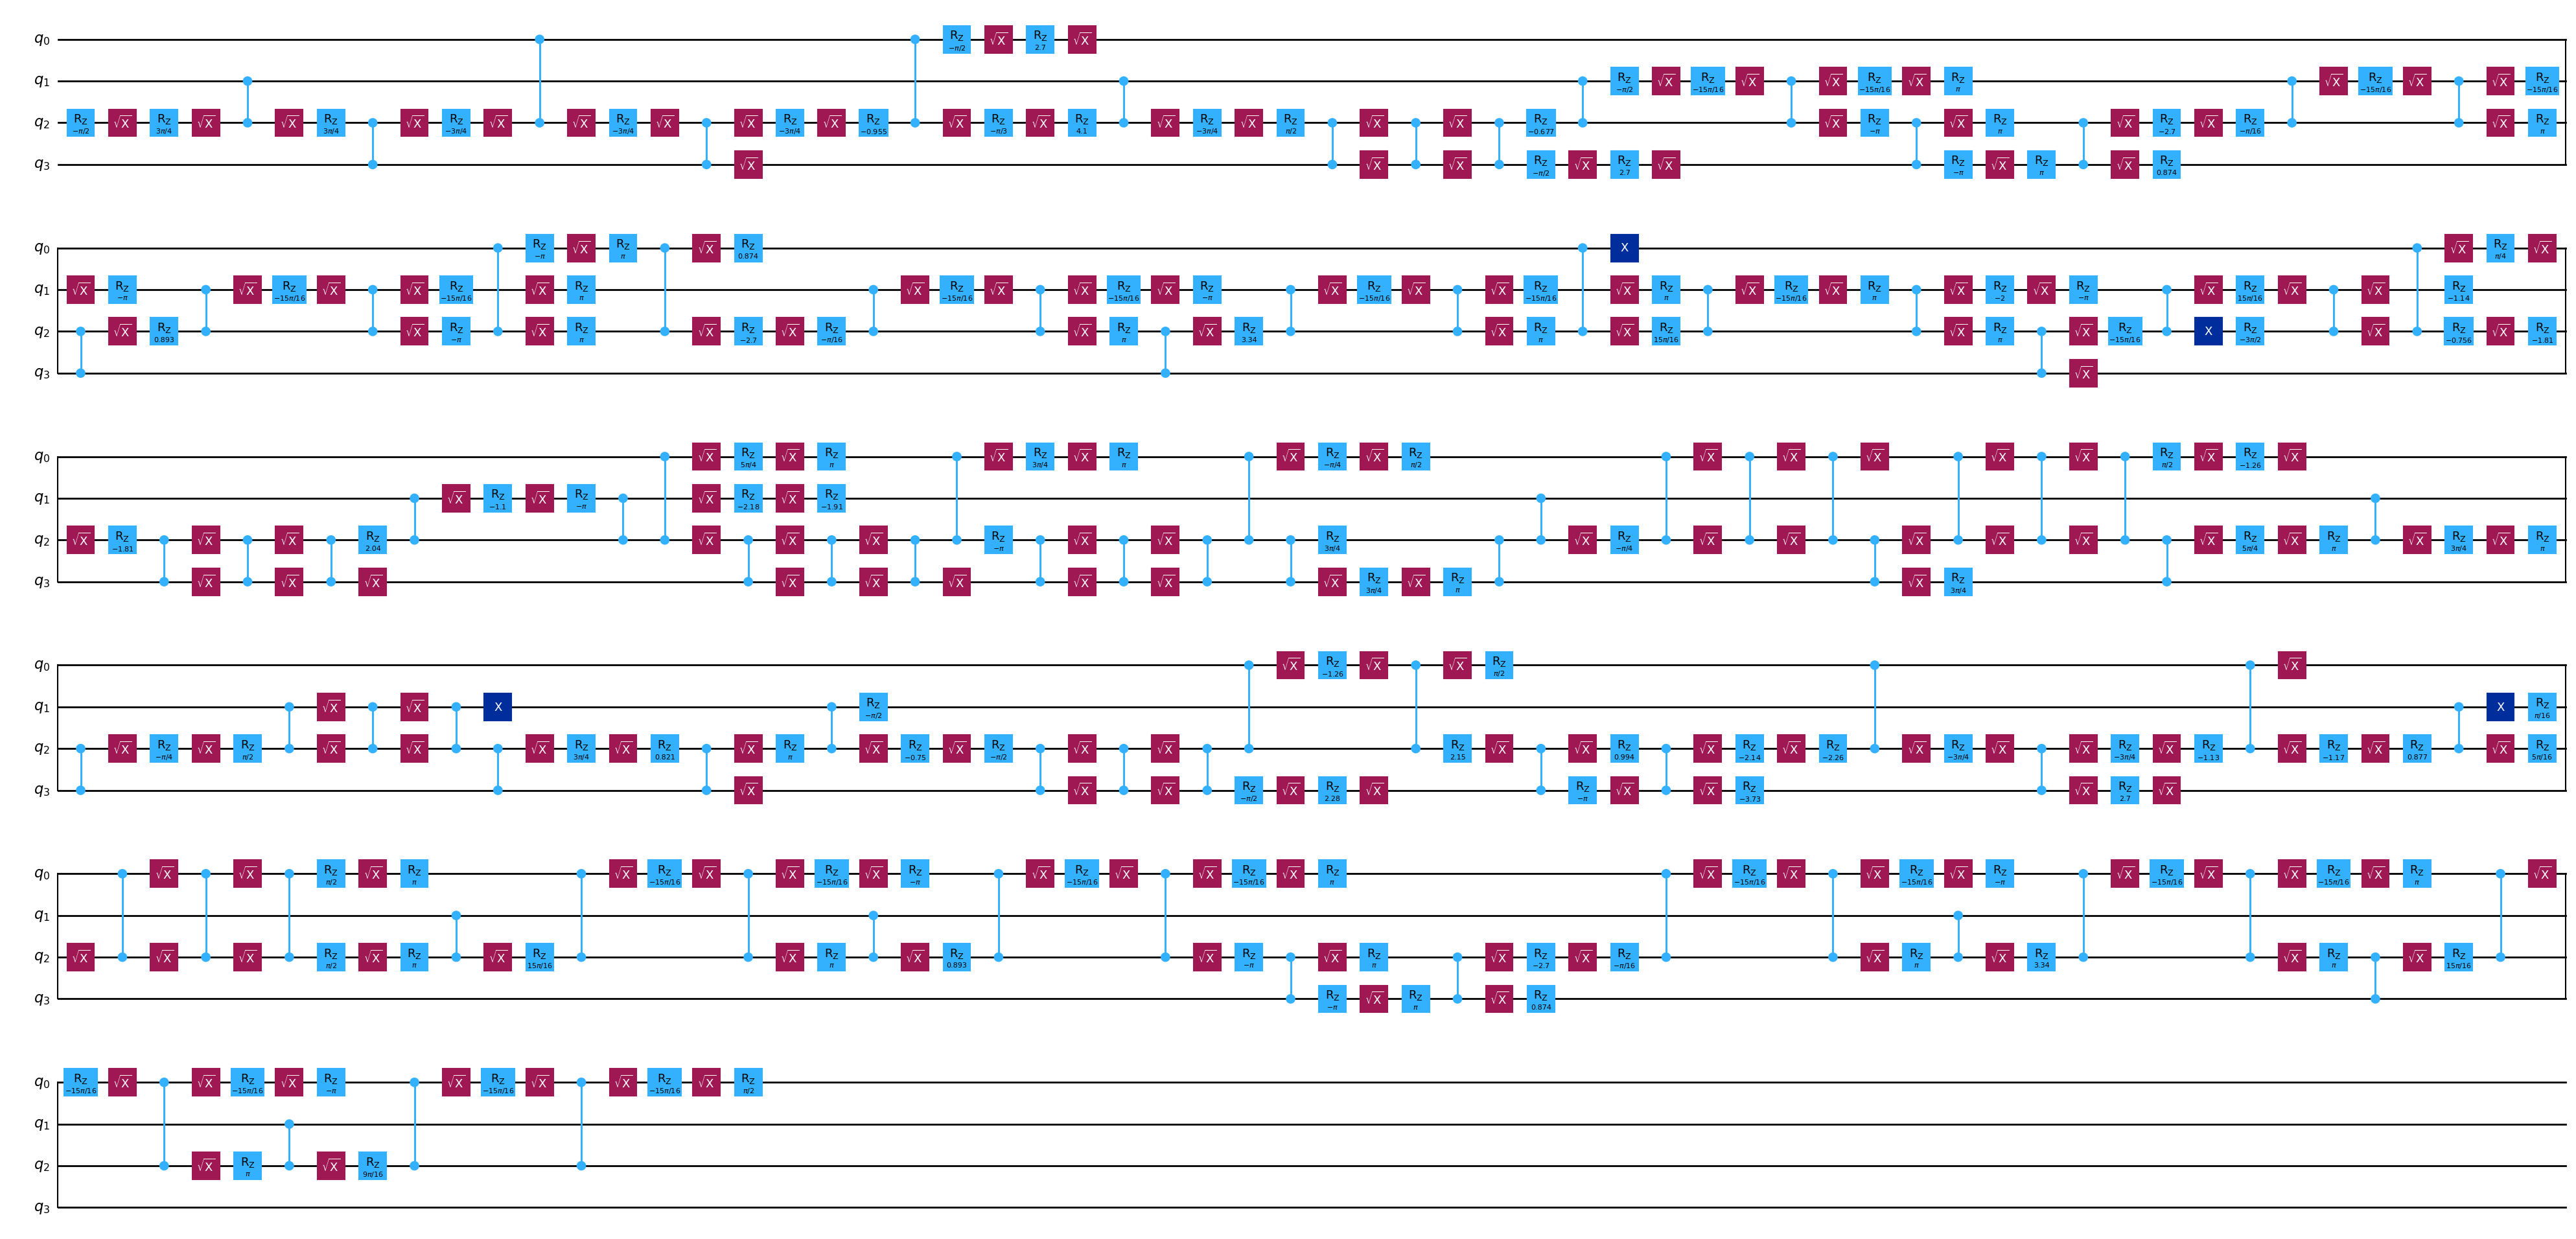

In [ ]:

# Run for our random circuit
pm_lv3 = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed)

tr_random = pm_lv3.run(qc1)
# print(tr_random.layout.initial_layout.get_virtual_bits())
# tr_random.draw('mpl', idle_wires=False, fold=60)

# phase = tr_lv0.global_phase
tr_random = copy_circuit_no_empty_lines(tr_random)

# uncomment the next line to draw circuit

tr_random.draw('mpl', idle_wires=False, fold=60)

In [458]:
sv1 = Statevector.from_instruction(qc1)
sv2 = Statevector.from_instruction(tr_random)
# are the two circuits equivalent?
print(sv1, sv2)
print("Are the two circuits equivalent?", sv1.equiv(sv2, rtol=1))

Statevector([ 0.40788658+0.j        , -0.27566389+0.08739543j,
              0.36739243+0.17718427j,  0.        +0.j        ,
              0.40788658+0.j        , -0.08739543+0.27566389j,
              0.36739243+0.17718427j,  0.        +0.j        ,
              0.        +0.j        ,  0.01006582+0.00144268j,
              0.        +0.j        , -0.04100291+0.28608372j,
              0.        +0.j        ,  0.2114602 -0.00613798j,
              0.        +0.j        , -0.00572074-0.19708557j],
            dims=(2, 2, 2, 2)) Statevector([-4.07100789e-01-2.53063126e-02j,
             -3.55691689e-01-1.99636881e-01j,
             -5.80565980e-18+1.88828450e-16j,
             -5.79643720e-17-2.21808806e-17j,
              2.80555054e-01-7.01241780e-02j,
              5.88784672e-17+8.83177008e-16j,
             -9.95691905e-03-2.06441154e-03j,
              5.86732762e-02-2.82988663e-01j,
             -4.07100789e-01-2.53063126e-02j,
             -3.55691689e-01-1.99636881e-01j,
    

In [454]:
from erft_quantum import erft
erft_result = erft(tr_random, qc1, epsilon=EPSILON, delta=DELTA, seed=seed)
print("ERTF result:", erft_result)

🔬 Starting ERFT for 4-qubit circuits...
   - ε (error tolerance): 0.2
   - δ (failure probability): 0.1
   - m (required samples): 38

🚀 Running 38 randomized trials...

📊 Results:
   - Total 'survival' counts: 3 / 38
   - Estimated Fidelity (F_hat): 0.0789
   - Decision Threshold (1 - ε): 0.8000
   - Outcome: F_hat < 1 - ε
ERTF result: ❌ Not equivalent
